# Notebook : 01_data_exploration.ipynb (structure JSON via code)
# 1 - Importation
## 1.1 - Librairies

In [1]:
# 🔧 Librairies de base
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import sys
from pathlib import Path


# 🖼️ Traitement d'images
import cv2
from PIL import Image
import albumentations as A

# 📚 Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.utils import img_to_array, load_img
from keras.models import Model
from keras.layers import Input

# 📊 Évaluation / Modèles
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 🧪 Tests éventuels
import pytest

# 🌱 Environnement
from dotenv import load_dotenv
load_dotenv()

# (optionnel, selon tracking)
import mlflow

# Ajout du chemin pour accéder aux modules
import sys
sys.path.append('../src')

## 1.2 - Configuration des chemins et environnement
- Chemins relatifs depuis notebooks/, vers data/ à la racine du projet

In [2]:
project_root = Path("..").resolve()
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

data_dir      = project_root / "data"
raw_dir       = data_dir / "raw"
processed_dir = data_dir / "processed"
models_dir    = project_root / "models"
outputs_dir   = project_root / "outputs"
scripts_dir   = project_root / "scripts"

# 📁 Dossiers images & masks plats
image_dir = raw_dir / "images"
mask_dir  = raw_dir / "masks"

# 📦 Fichiers de données transformées
train_path = processed_dir / "train.npz"
val_path   = processed_dir / "val.npz"
test_path  = processed_dir / "test.npz"

### 1.2.1 - Import de modules maison

In [3]:
from data_preprocessing.preprocessing import prepare_dataset
from data_preprocessing.class_mapping import CLASS_MAPPING_P8

### 1.2.1 - Visualisation de l'arborescence du projet

In [4]:
def display_tree(start_path = '.', max_level = 2, prefix = ''):
    start_path = Path(start_path)
    if max_level < 0:
        return
    for path in sorted(start_path.iterdir()):
        if path.name.startswith('.'):
            continue  # ignore fichiers cachés
        print(f"{prefix}├── {path.name}")
        if path.is_dir():
            display_tree(path, max_level - 1, prefix + "│   ")

In [5]:
display_tree("..", max_level = 2)

├── api
├── app
├── data
│   ├── P8_Cityscapes_gtFine_trainvaltest
│   │   ├── gtFine
│   │   ├── license.txt
│   │   ├── README
│   ├── P8_Cityscapes_leftImg8bit_trainvaltest
│   │   ├── leftImg8bit
│   │   ├── license.txt
│   │   ├── README
│   ├── processed
│   │   ├── test.npz
│   │   ├── train.npz
│   │   ├── val.npz
│   ├── raw
│   │   ├── images
│   │   ├── masks
├── Makerfile
├── models
│   ├── best_unet_vgg16.h5
│   ├── best_unet_vgg16_history.pkl
│   ├── unet_vgg16.h5
│   ├── unet_vgg16_history.pkl
│   ├── unet_vgg16_metrics.csv
│   ├── unet_vgg16_test.h5
│   ├── unet_vgg16_test_history.pkl
│   ├── unet_vgg16_test_metrics.csv
│   ├── unet_vgg16_test_training_plot.png
│   ├── unet_vgg16_training_plot.png
├── notebooks
│   ├── 01_data_exploration.ipynb
│   ├── 02_model_training_unet.ipynb
│   ├── 03_model_training_unet_vgg16.ipynb
│   ├── mlartifacts
│   │   ├── 844602476156013816
│   ├── mlruns
│   │   ├── 0
│   │   ├── models
│   ├── models
│   │   ├── unet_mini_cityscapes_12

In [6]:
CLASS_MAPPING_P8 = {
    0: "road",
    1: "sidewalk",
    2: "building",
    3: "wall",
    4: "fence",
    5: "pole",
    6: "traffic light",
    7: "vegetation"
}

In [7]:
print("🧾 Mapping des classes (ID → Nom) :\n")
for class_id, class_name in CLASS_MAPPING_P8.items():
    print(f"  Classe {class_id} : {class_name}")


🧾 Mapping des classes (ID → Nom) :

  Classe 0 : road
  Classe 1 : sidewalk
  Classe 2 : building
  Classe 3 : wall
  Classe 4 : fence
  Classe 5 : pole
  Classe 6 : traffic light
  Classe 7 : vegetation


# 2 - Extraction des données à plat

In [8]:
if not image_dir.exists() or not any(image_dir.iterdir()):
    print("[INFO] Dossiers plats absents ou vides. Extraction en cours...")
    os.system(f"python {scripts_dir / 'extract_cityscapes_flat.py'}")
else:
    print("[INFO] Données déjà extraites dans data/raw/")

[INFO] Données déjà extraites dans data/raw/


## 2 - Prétraitement et génération des données transformées
- Le bloc appelle le pipeline complet :
    - parcourt récursivement tous les fichiers images/masks
    - resize, normalisation, mapping 8 classes
    - split en train/val/test + sauvegarde .npz
    - tracking MLflow (params + artefacts)
## 2.1 - Génération des fichiers .npz

In [9]:
if not (train_path.exists() and val_path.exists() and test_path.exists()):
    print("[INFO] Fichiers .npz absents. Lancement du preprocessing.")
    prepare_dataset(
        image_dir=image_dir,
        mask_dir=mask_dir,
        output_dir=processed_dir,
        img_size=(256, 256),
        mapping_dict=CLASS_MAPPING_P8
    )
else:
    print("[INFO] Fichiers .npz déjà présents. Pas de preprocessing nécessaire.")

[INFO] Fichiers .npz déjà présents. Pas de preprocessing nécessaire.


# 3 - Chargement des données prétraitées

In [10]:
train = np.load(train_path)
val   = np.load(val_path)
test  = np.load(test_path)

X_train, y_train = train["X"], train["Y"]
X_val, y_val     = val["X"], val["Y"]
X_test, y_test   = test["X"], test["Y"]

# 4 - Visualisation d'une image et de son mask

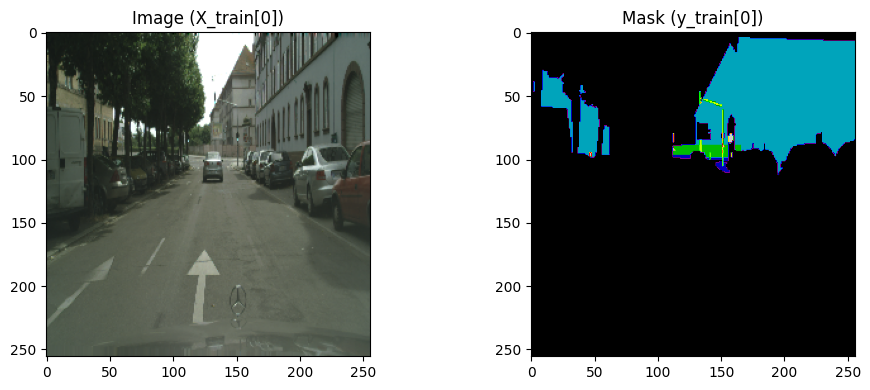

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.title("Image (X_train[0])")

plt.subplot(1, 2, 2)
plt.imshow(y_train[0], cmap="nipy_spectral")
plt.title("Mask (y_train[0])")
plt.tight_layout()
plt.show()

# 5 - Analyse des dimensions

In [12]:
print("[INFO] Taille des images :", X_train.shape[1:])
print("[INFO] Taille des masks  :", y_train.shape[1:])
print("[INFO] Nombre d'images d'entraînement :", X_train.shape[0])

[INFO] Taille des images : (256, 256, 3)
[INFO] Taille des masks  : (256, 256)
[INFO] Nombre d'images d'entraînement : 4000


# 6 - Valeurs uniques dans les masks (pour vérification du mapping)

In [13]:
unique_labels = np.unique(y_train)
print("[INFO] Labels uniques dans y_train :", unique_labels)

[INFO] Labels uniques dans y_train : [0 1 2 3 4 5 6 7]


# 7 - Distribution des classes (comptage de pixels par label)

In [14]:
def get_class_distribution(masks):
    flat = masks.flatten()
    counts = np.bincount(flat[flat != 255], minlength=8)
    return counts

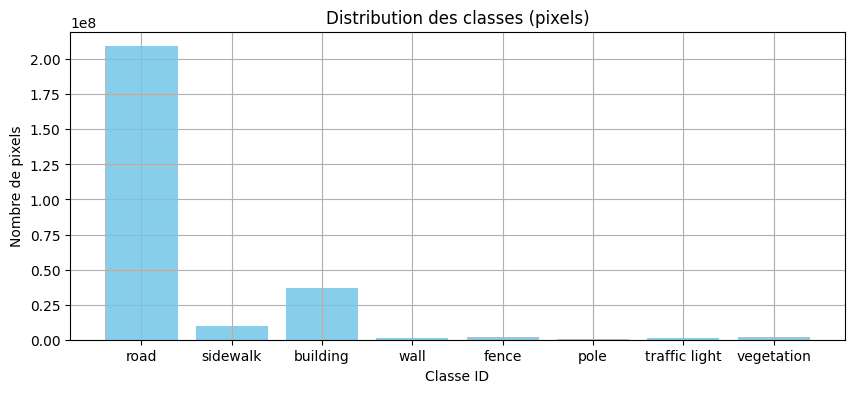

In [15]:
class_counts = get_class_distribution(y_train)
plt.figure(figsize=(10, 4))
plt.bar(range(8), class_counts, color="skyblue")
plt.title("Distribution des classes (pixels)")
plt.xlabel("Classe ID")
plt.ylabel("Nombre de pixels")
plt.xticks(range(8), list(CLASS_MAPPING_P8.values()))
plt.grid(True)
plt.show()

# 8 - Grille d’images avec masks superposés

In [16]:
def show_image_mask_grid(images, masks, n=5):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        idx = random.randint(0, len(images) - 1)
        plt.subplot(2, n, i+1)
        plt.imshow(images[idx])
        plt.axis("off")
        plt.title(f"Image {idx}")

        plt.subplot(2, n, i+1+n)
        plt.imshow(masks[idx], cmap="nipy_spectral")
        plt.axis("off")
        plt.title(f"Mask {idx}")
    plt.tight_layout()
    plt.show()

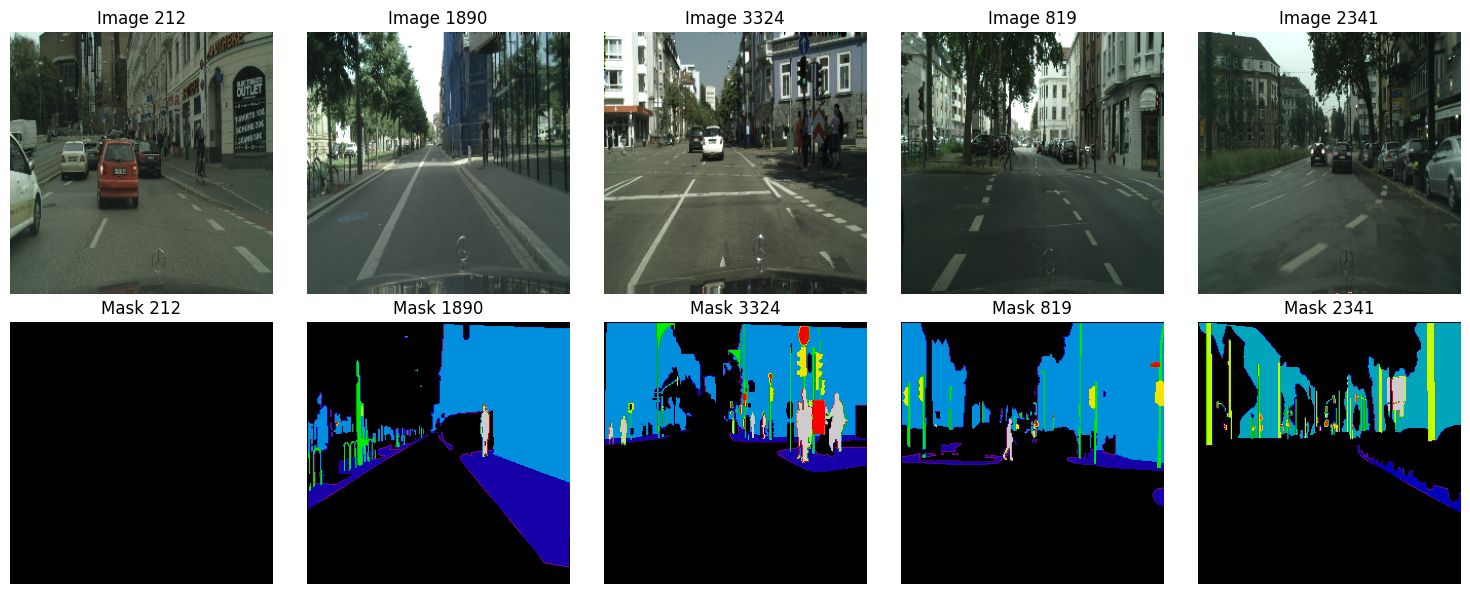

In [17]:
show_image_mask_grid(X_train, y_train)

# 9 - Comparaison des distributions entre train, val, test

[INFO] Comparaison des proportions de classes entre sets


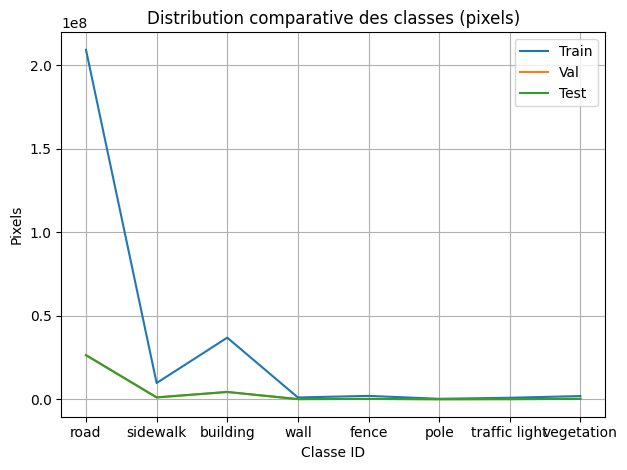

In [18]:
print("[INFO] Comparaison des proportions de classes entre sets")
for label_set, name in zip([y_train, y_val, y_test], ["Train", "Val", "Test"]):
    counts = get_class_distribution(label_set)
    plt.plot(range(8), counts, label=name)

plt.title("Distribution comparative des classes (pixels)")
plt.xlabel("Classe ID")
plt.ylabel("Pixels")
plt.xticks(range(8), list(CLASS_MAPPING_P8.values()))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()